In [1]:
# Imports
import torch, math
import numpy as np
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn.modules.transformer import TransformerEncoderLayer

In [2]:
# Positional Encoding - https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


In [3]:
# A forcasting model
class ForecastingModel(torch.nn.Module):
    def __init__(self,
                 seq_len=200,
                 embed_size = 16,
                 nhead = 4,
                 dim_feedforward = 2048,
                 dropout = 0.1,
                 conv1d_emb = True,
                 conv1d_kernel_size = 3,
                 device = "cuda"):
        super(ForecastingModel, self).__init__()

        # Set Class-level Parameters
        self.device = device
        self.conv1d_emb = conv1d_emb
        self.conv1d_kernel_size = conv1d_kernel_size
        self.seq_len = seq_len
        self.embed_size = embed_size

        # Input Embedding Component
        if conv1d_emb:
            if conv1d_kernel_size%2==0:
                raise Exception("conv1d_kernel_size must be an odd number to preserve dimensions.")
            self.conv1d_padding = conv1d_kernel_size - 1
            self.input_embedding  = nn.Conv1d(1, embed_size, kernel_size=conv1d_kernel_size)
        else: self.input_embedding  = nn.Linear(1, embed_size)

        # Positional Encoder Componet (See Code Copied from PyTorch Above)
        self.position_encoder = PositionalEncoding(d_model=embed_size,
                                                   dropout=dropout,
                                                   max_len=seq_len)

        # Transformer Encoder Layer Component
        self.transformer_encoder = TransformerEncoderLayer(
            d_model = embed_size,
            nhead = nhead,
            dim_feedforward = dim_feedforward,
            dropout = dropout,
            batch_first = True
        )

        # Regression Component
        self.linear1 = nn.Linear(seq_len*embed_size, int(dim_feedforward))
        self.linear2 = nn.Linear(int(dim_feedforward), int(dim_feedforward/2))
        self.linear3 = nn.Linear(int(dim_feedforward/2), int(dim_feedforward/4))
        self.linear4 = nn.Linear(int(dim_feedforward/4), int(dim_feedforward/16))
        self.linear5 = nn.Linear(int(dim_feedforward/16), int(dim_feedforward/64))
        self.outlayer = nn.Linear(int(dim_feedforward/64), 1)

        # Basic Components
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    # Model Forward Pass
    def forward(self, x):
        src_mask = self._generate_square_subsequent_mask()
        src_mask.to(self.device)
        if self.conv1d_emb:
            x = F.pad(x, (0, 0, self.conv1d_padding, 0), "constant", -1)
            x = self.input_embedding(x.transpose(1, 2))
            x = x.transpose(1, 2)
        else:
            x = self.input_embedding(x)
        x = self.position_encoder(x)
        x = self.transformer_encoder(x, src_mask=src_mask).reshape((-1, self.seq_len*self.embed_size))
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear5(x)
        x = self.relu(x)
        return self.outlayer(x)

    # Function Copied from PyTorch Library to create upper-triangular source mask
    def _generate_square_subsequent_mask(self):
        return torch.triu(
            torch.full((self.seq_len, self.seq_len), float('-inf'), dtype=torch.float32, device=self.device),
            diagonal=1,
        )

***Testy***

1.   Sinus

In [ ]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
#from forecasting_model import ForecastingModel
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import TensorDataset, DataLoader

# Get a noisy sin wave
DATA_SIZE = 1000
x = np.sin(np.linspace(0, 10, DATA_SIZE))
x = x + np.random.normal(0, 0.05, DATA_SIZE)


# Create a dataset
seq_len = 200
X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, seq_len, 1))
Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, 1))


# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

EPOCHS = 30
BATCH_SIZE = 1
LEARNING_RATE = 2.2e-6
model = ForecastingModel(seq_len, embed_size=8, nhead=2, dim_feedforward=1024, dropout=0, device=device)
model.to(device)
model.train()
criterion = torch.nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.9)
dataset = TensorDataset(torch.Tensor(X).to(device), torch.Tensor(Y).to(device))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
for epoch in range(EPOCHS):
    for xx, yy in dataloader:
        optimizer.zero_grad()
        out = model(xx)
        loss = criterion(out, yy)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS}: Loss={loss}")


Using device: cuda
Epoch 1/30: Loss=0.16782058775424957
Epoch 2/30: Loss=0.05610470473766327
Epoch 3/30: Loss=0.005033137742429972
Epoch 4/30: Loss=0.0015243152156472206
Epoch 5/30: Loss=0.003699678461998701
Epoch 6/30: Loss=0.0022782052401453257
Epoch 7/30: Loss=0.0008702357881702483
Epoch 8/30: Loss=0.00039569358341395855
Epoch 9/30: Loss=0.00019219049136154354
Epoch 10/30: Loss=7.077672489685938e-05
Epoch 11/30: Loss=1.2875582797278184e-05
Epoch 12/30: Loss=7.655700073883054e-09
Epoch 13/30: Loss=9.508786206424702e-06
Epoch 14/30: Loss=2.609928560559638e-05
Epoch 15/30: Loss=4.3380299757700413e-05
Epoch 16/30: Loss=6.515593122458085e-05
Epoch 17/30: Loss=7.807493966538459e-05
Epoch 18/30: Loss=9.758485975908116e-05
Epoch 19/30: Loss=0.00013705492892768234
Epoch 20/30: Loss=0.00016949966084212065
Epoch 21/30: Loss=0.00019765572506003082
Epoch 22/30: Loss=0.0002211469254689291
Epoch 23/30: Loss=0.0002368899149587378
Epoch 24/30: Loss=0.00025025734794326127
Epoch 25/30: Loss=0.00025999

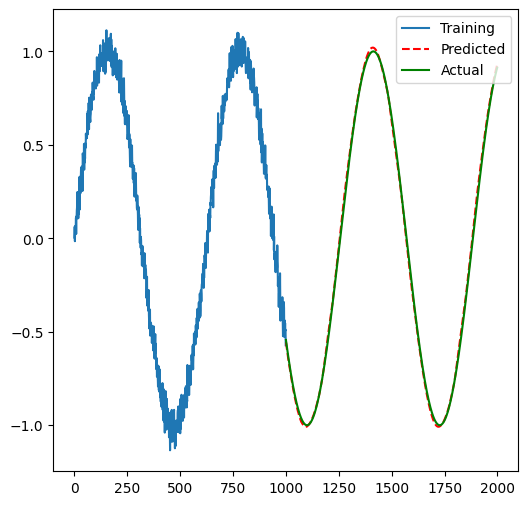

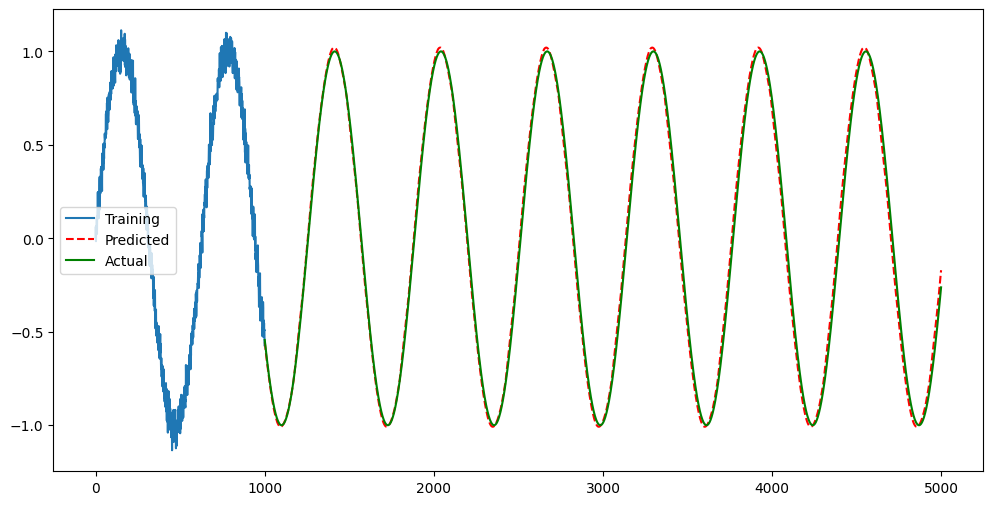

In [ ]:
# Prediction Loop
FORCAST = 1000
model.eval()
for ff in range(FORCAST):
    xx = x[len(x)-seq_len:len(x)]
    yy = model(torch.Tensor(xx).reshape(1, xx.shape[0], 1).to(device))
    x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))


# Plot Predictions
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6))
plt.plot(range(x[:DATA_SIZE].shape[0]), x[:DATA_SIZE], label="Training")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), x[DATA_SIZE:DATA_SIZE+FORCAST], 'r--', label="Predicted")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), np.sin(np.linspace(10, 20, DATA_SIZE)), 'g-', label="Actual")
plt.legend()
#fig.savefig("./img/sine_example.png")


# Prediction Loop
FORCAST_EXTENDED = 3000
model.eval()
for ff in range(FORCAST_EXTENDED):
    xx = x[len(x)-seq_len:len(x)]
    yy = model(torch.Tensor(xx).reshape(1, xx.shape[0], 1).to(device))
    x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))


# Plot Predictions
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
plt.plot(range(x[:DATA_SIZE].shape[0]), x[:DATA_SIZE], label="Training")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), x[DATA_SIZE:DATA_SIZE+FORCAST+FORCAST_EXTENDED], 'r--', label="Predicted")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), np.sin(np.linspace(10, 50, FORCAST+FORCAST_EXTENDED)), 'g-', label="Actual")
plt.legend()
#fig.savefig("./img/sine_extended.png")

2.   Plamy słoneczne

In [ ]:
names = ['year', 'month', 'day', 'dec_year', 'sn_value', 'sn_error',
         'obs_num', 'unsed1']

#df = pd.read_csv('/content/SN_d_tot_V2.0.csv',
#            sep=';', header=None, names=names,
#            na_values=['-1'], index_col=False)

df = pd.read_csv('https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv',
            sep=';', header=None, names=names,
            na_values=['-1'], index_col=False)

df.head()

,year,month,day,dec_year,sn_value,sn_error,obs_num,unsed1
0,1818,1,1,1818.001,-1,NaN,0,1
1,1818,1,2,1818.004,-1,NaN,0,1
2,1818,1,3,1818.007,-1,NaN,0,1
3,1818,1,4,1818.010,-1,NaN,0,1
4,1818,1,5,1818.012,-1,NaN,0,1


In [ ]:
start_id = max(df[df['obs_num'] == 0].index.tolist()) + 1
df1 = df.iloc[start_id:].copy()
df1['sn_value'] = df1['sn_value'].astype(float)
df1['date'] = pd.to_datetime(df1[['year', 'month', 'day']])
df1.head()

df2 = df1[['date', 'sn_value']].copy().reset_index(drop=True)
df2['month'] = df2['date'].dt.to_period('M')
df2 = df2.groupby('month')['sn_value'].mean().reset_index()
df2['month'] = df2['month'].dt.to_timestamp()
df2 = df2.rename(columns={'month': 'date'})
df2.head()

,date,sn_value
0,1848-12-01,299.333333
1,1849-01-01,298.290323
2,1849-02-01,250.250000
3,1849-03-01,182.741935
4,1849-04-01,194.700000


In [ ]:
#Imports
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from forecasting_model import ForecastingModel
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error)


N_start = 1900
# Create a dataset
seq_len = 300
data = list(df2["sn_value"])#[1000:]
x = np.array(data[:N_start])
forcast = np.array(data[N_start:])
X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, seq_len, 1))
Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, 1))


# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

EPOCHS = 30
BATCH_SIZE = 1
LEARNING_RATE = 6.6E-6
model = ForecastingModel(seq_len, embed_size=8, nhead=2,
                         dim_feedforward=1024, dropout=0,
                         conv1d_emb=False, conv1d_kernel_size=5, device=device).to(device)
model.train()
criterion = torch.nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.9)
dataset = TensorDataset(torch.Tensor(X).to(device), torch.Tensor(Y).to(device))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
for epoch in range(EPOCHS):
    for xx, yy in dataloader:
        optimizer.zero_grad()
        out = model(xx)
        loss = criterion(out, yy)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS}: Loss={loss}")




Using device: cuda
Epoch 1/30: Loss=68.51254272460938
Epoch 2/30: Loss=37.271240234375
Epoch 3/30: Loss=5.563424110412598
Epoch 4/30: Loss=4.9861040115356445
Epoch 5/30: Loss=5.52021598815918
Epoch 6/30: Loss=5.995757102966309
Epoch 7/30: Loss=6.905338287353516
Epoch 8/30: Loss=7.6073713302612305
Epoch 9/30: Loss=8.43797492980957
Epoch 10/30: Loss=9.239980697631836
Epoch 11/30: Loss=9.803487777709961
Epoch 12/30: Loss=10.377336502075195
Epoch 13/30: Loss=10.73440933227539
Epoch 14/30: Loss=10.947854995727539
Epoch 15/30: Loss=11.127405166625977
Epoch 16/30: Loss=11.205526351928711
Epoch 17/30: Loss=11.14208984375
Epoch 18/30: Loss=11.134225845336914
Epoch 19/30: Loss=11.130914688110352
Epoch 20/30: Loss=11.124414443969727
Epoch 21/30: Loss=11.121944427490234
Epoch 22/30: Loss=11.134592056274414
Epoch 23/30: Loss=11.072635650634766
Epoch 24/30: Loss=10.985612869262695
Epoch 25/30: Loss=10.852094650268555
Epoch 26/30: Loss=10.685720443725586
Epoch 27/30: Loss=10.5035400390625
Epoch 28/30

In [ ]:
# Prediction Loop
model.eval()
for ff in range(len(forcast)):
    xx = x[len(x)-seq_len:len(x)]
    yy = model(torch.Tensor(xx).reshape((1, seq_len, 1)).to(device))
    x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))

MSE: 5087.171395053107
MAE: 55.510290234670684


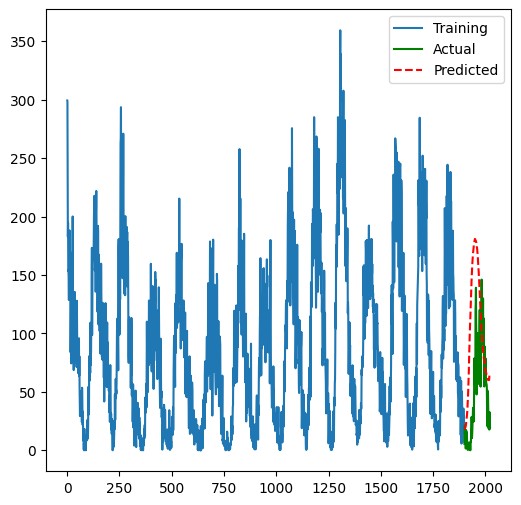

In [ ]:
# Plot Predictions
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6))
plt.plot(range(N_start), data[:N_start], label="Training")
plt.plot(range(N_start, len(data)), forcast, 'g-', label="Actual")
plt.plot(range(N_start, len(data)), x[N_start:], 'r--', label="Predicted")
plt.legend()
#fig.savefig("./img/sunspots_example.png")


# Export Metrics
print(f"MSE: {mean_squared_error(x[N_start:], forcast)}")
print(f"MAE: {mean_absolute_error(x[N_start:], forcast)}")

3.   Pogoda w Krakowie

In [ ]:
!pip install requests zipfile36

In [4]:
import requests
import zipfile
import pandas as pd
import io

# "https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/klimat/"

csv_filename = "k_d_t_01_2022.csv" #"k_d_01_2022.csv"
columns = ['Kod stacji', 'Nazwa stacji', 'Rok', 'Miesiąc', 'Dzień',
           'Średnia dobowa temperatura [°C]', 'Status pomiaru TEMP',
           'Średnia dobowa wilgotność względna [%]', 'Status pomiaru WLGS',
           'Średnia dobowa prędkość wiatru [m/s]', 'Status pomiaru FWS',
           'Średnie dobowe zachmurzenie ogólne [oktanty]', 'Status pomiaru NOS']
columns = [c.replace(' ', '_') for c in columns]
url_0 = "https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/klimat/"
df_all = pd.DataFrame(columns=columns)

for year in range(2018, 2026):
  for month in range(1, 13):

    zip_filename = "_".join([str(year), f'{month:02d}', 'k']) + ".zip"
    csv_filename = "_".join(['k', 'd', 't', f'{month:02d}', str(year)]) + ".csv"
    url = url_0 + str(year) + "/" + zip_filename

    try:
      response = requests.get(url, stream=True)
      response.raise_for_status()  # Raise an exception for bad status codes

      with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
          for file_info in zip_ref.infolist():
            #print(csv_filename)
            #print(file_info.filename)
            if file_info.filename == csv_filename:
                with zip_ref.open(file_info) as csv_file:
                    df = pd.read_csv(csv_file,sep=',', encoding='cp1252', header=None)
                    df.columns = columns
                    df_all = pd.concat([df_all, df], ignore_index=True)

    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
        #return None
    except zipfile.BadZipFile:
        print(f"Error: Invalid zip file.")
        #return None
    except Exception as e:
      print(f"An unexpected error occurred: {e}")
        #return None

df_all.head()

<ipython-input-4-36dfd6f02f6e>:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df], ignore_index=True)


Error downloading file: 404 Client Error: Not Found for url: https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/klimat/2025/2025_02_k.zip
Error downloading file: 404 Client Error: Not Found for url: https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/klimat/2025/2025_03_k.zip
Error downloading file: 404 Client Error: Not Found for url: https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/klimat/2025/2025_04_k.zip
Error downloading file: 404 Client Error: Not Found for url: https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/klimat/2025/2025_05_k.zip
Error downloading file: 404 Client Error: Not Found for url: https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/klimat/2025/2025_06_k.zip
Error downloading file: 404 Client Error: Not Found for url: https://danepubliczne.imgw.pl/data/dane_pomiarowo

,Kod_stacji,Nazwa_stacji,Rok,Miesiąc,Dzień,Średnia_dobowa_temperatura_[°C],Status_pomiaru_TEMP,Średnia_dobowa_wilgotność_względna_[%],Status_pomiaru_WLGS,Średnia_dobowa_prędkość_wiatru_[m/s],Status_pomiaru_FWS,Średnie_dobowe_zachmurzenie_ogólne_[oktanty],Status_pomiaru_NOS
0,249180010,PSZCZYNA,2018,1,1,5.0,NaN,0.0,8.0,0.0,8.0,6.7,NaN
1,249180010,PSZCZYNA,2018,1,2,0.8,NaN,0.0,8.0,0.0,8.0,5.3,NaN
2,249180010,PSZCZYNA,2018,1,3,2.8,NaN,0.0,8.0,0.0,8.0,5.0,NaN
3,249180010,PSZCZYNA,2018,1,4,5.0,NaN,0.0,8.0,0.0,8.0,3.7,NaN
4,249180010,PSZCZYNA,2018,1,5,7.0,NaN,0.0,8.0,0.0,8.0,6.0,NaN


In [5]:
df_KRK = df_all[df_all['Nazwa_stacji'] == 'KRAKÓW-OBSERWATORIUM']
df_KRK.head()

,Kod_stacji,Nazwa_stacji,Rok,Miesiąc,Dzień,Średnia_dobowa_temperatura_[°C],Status_pomiaru_TEMP,Średnia_dobowa_wilgotność_względna_[%],Status_pomiaru_WLGS,Średnia_dobowa_prędkość_wiatru_[m/s],Status_pomiaru_FWS,Średnie_dobowe_zachmurzenie_ogólne_[oktanty],Status_pomiaru_NOS
1023,250190390,KRAKÓW-OBSERWATORIUM,2018,1,1,4.2,NaN,89.3,NaN,1.0,NaN,6.0,NaN
1024,250190390,KRAKÓW-OBSERWATORIUM,2018,1,2,1.9,NaN,87.3,NaN,1.3,NaN,5.3,NaN
1025,250190390,KRAKÓW-OBSERWATORIUM,2018,1,3,3.1,NaN,77.0,NaN,2.0,NaN,5.3,NaN
1026,250190390,KRAKÓW-OBSERWATORIUM,2018,1,4,5.0,NaN,78.3,NaN,1.7,NaN,3.7,NaN
1027,250190390,KRAKÓW-OBSERWATORIUM,2018,1,5,5.4,NaN,81.3,NaN,1.0,NaN,6.7,NaN


In [6]:
# prompt: Dla ramki df_KRK chcę uśrednić wszystkie wyniki po mięsiącach dla każdego roku.

# Group by year and month, then calculate the mean of 'Średnia dobowa temperatura [°C]'
df_KRK_monthly_temp = df_KRK.groupby(['Rok', 'Miesiąc'])['Średnia_dobowa_temperatura_[°C]'].mean().reset_index()['Średnia_dobowa_temperatura_[°C]']
df_KRK_temp = df_KRK['Średnia_dobowa_temperatura_[°C]'].reset_index(drop=True)
df_KRK_temp

,Średnia_dobowa_temperatura_[°C]
0,4.2
1,1.9
2,3.1
3,5.0
4,5.4
...,...
2307,8.7
2308,11.2
2309,13.8
2310,17.8


<Axes: >

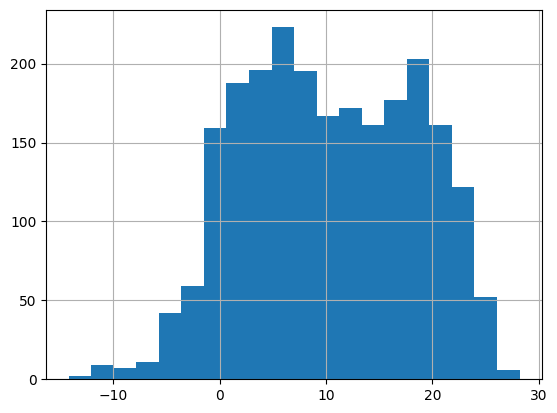

In [7]:
df_KRK_temp.hist(bins=20)

In [8]:
#Imports
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from forecasting_model import ForecastingModel
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error)


N_start = 1500
# Create a dataset
seq_len = 300
data = list(df_KRK_temp)
x = np.array(data[:N_start])
forcast = np.array(data[N_start:])
X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, seq_len, 1))
Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, 1))


# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

EPOCHS = 30
BATCH_SIZE = 1
LEARNING_RATE = 6.6E-6
model = ForecastingModel(seq_len, embed_size=8, nhead=2,
                         dim_feedforward=1024, dropout=0,
                         conv1d_emb=False, conv1d_kernel_size=5, device=device).to(device)
model.train()
criterion = torch.nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.9)
dataset = TensorDataset(torch.Tensor(X).to(device), torch.Tensor(Y).to(device))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
for epoch in range(EPOCHS):
    for xx, yy in dataloader:
        optimizer.zero_grad()
        out = model(xx)
        loss = criterion(out, yy)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS}: Loss={loss}")




Using device: cuda
Epoch 1/30: Loss=0.011636657640337944
Epoch 2/30: Loss=0.45880383253097534
Epoch 3/30: Loss=2.933211326599121
Epoch 4/30: Loss=2.798574447631836
Epoch 5/30: Loss=2.4751250743865967
Epoch 6/30: Loss=2.2918028831481934
Epoch 7/30: Loss=2.2529032230377197
Epoch 8/30: Loss=2.2534875869750977
Epoch 9/30: Loss=2.2551381587982178
Epoch 10/30: Loss=2.2618799209594727
Epoch 11/30: Loss=2.2699873447418213
Epoch 12/30: Loss=2.2747995853424072
Epoch 13/30: Loss=2.276940107345581
Epoch 14/30: Loss=2.2743775844573975
Epoch 15/30: Loss=2.2683568000793457
Epoch 16/30: Loss=2.2573776245117188
Epoch 17/30: Loss=2.2428886890411377
Epoch 18/30: Loss=2.2183523178100586
Epoch 19/30: Loss=2.1908130645751953
Epoch 20/30: Loss=2.1594271659851074
Epoch 21/30: Loss=2.128425121307373
Epoch 22/30: Loss=2.096653699874878
Epoch 23/30: Loss=2.0630152225494385
Epoch 24/30: Loss=2.0317721366882324
Epoch 25/30: Loss=2.0025382041931152
Epoch 26/30: Loss=1.9722046852111816
Epoch 27/30: Loss=1.9437422752

In [17]:
# Prediction Loop
model.eval()
for ff in range(len(forcast)):
    xx = x[len(x)-seq_len:len(x)]
    yy = model(torch.Tensor(xx).reshape((1, seq_len, 1)).to(device))
    x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))

MSE: 16.966338810909587
MAE: 3.286187801836747


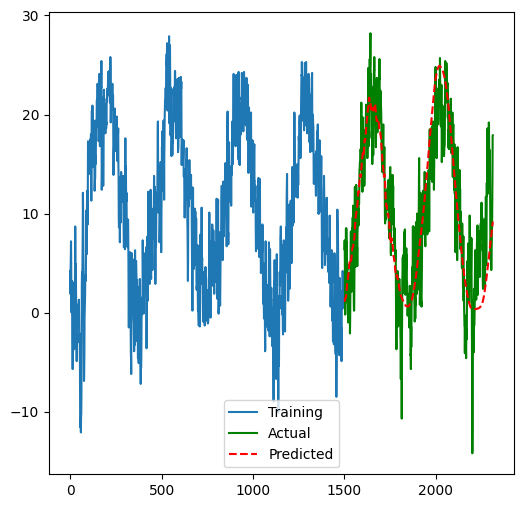

In [20]:
# Plot Predictions
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6))
plt.plot(range(N_start), data[:N_start], label="Training")
plt.plot(range(N_start, len(data)), forcast, 'g-', label="Actual")
plt.plot(range(N_start, len(data)), x[N_start:], 'r--', label="Predicted")
plt.legend()
#fig.savefig("./img/sunspots_example.png")


# Export Metrics
print(f"MSE: {mean_squared_error(x[N_start:], forcast)}")
print(f"MAE: {mean_absolute_error(x[N_start:], forcast)}")